# Judul : Forecasting Menggunakan Algoritma GRU Menggunakan Dataset Annual CO₂ emissions from land-use change, 1860 to 2023

Latar Belakang : Emisi karbon dioksida (CO₂) dari perubahan penggunaan lahan merupakan salah satu penyebab utama perubahan iklim global. Untuk mengatasi dampaknya, diperlukan kemampuan memprediksi tren emisi di masa depan secara akurat. Dalam era digital, metode deep learning seperti Gated Recurrent Unit (GRU) memberikan pendekatan yang efektif untuk analisis data deret waktu.

Penelitian ini menggunakan algoritma GRU untuk memprediksi emisi CO₂ tahunan berdasarkan data historis dari tahun 1860 hingga 2023. Dengan pendekatan multi-step forecasting, model ini diharapkan dapat membantu memahami pola emisi serta mendukung perumusan kebijakan lingkungan yang lebih tepat sasaran.

GRU (Gated Recurrent Unit) adalah algoritma deep learning berbasis Recurrent Neural Network (RNN) yang dirancang untuk memproses data berurutan seperti deret waktu. GRU menggunakan dua gerbang utama (update dan reset gate) untuk mengontrol aliran informasi, sehingga mampu mengingat pola penting dalam data masa lalu tanpa mengalami masalah vanishing gradient. Dalam forecasting, GRU digunakan untuk memprediksi nilai masa depan berdasarkan data historis, dengan keunggulan lebih ringan dan cepat dibanding LSTM.

# Menambahkan Libary Dan Mengimport Dataset

In [ ]:
# Menginstal dua library Python, yaitu pycountry dan pycountry-convert, yang akan digunakan untuk keperluan mengidentifikasi data negara dan mengonversinya ke dalam informasi benua.
!pip install pycountry pycountry-convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 19.5 MB/s eta 0:00:00


In [ ]:
# Menginstall Library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
import pycountry_convert as pc
import pycountry
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input

Model ini mengimpor berbagai library yang dibutuhkan untuk membangun model prediksi menggunakan jaringan saraf GRU (Gated Recurrent Unit) berbasis TensorFlow. pandas dan numpy digunakan untuk manipulasi data, matplotlib.pyplot untuk visualisasi, dan MinMaxScaler dari sklearn untuk normalisasi data. Sequential, GRU, Dense, Dropout, dan Input dari tensorflow.keras digunakan untuk membangun dan melatih model deep learning. mean_squared_error digunakan untuk mengevaluasi performa model, sedangkan train_test_split membagi data menjadi data latih dan uji. Library pycountry dan pycountry_convert memungkinkan konversi data negara ke kode atau benua, jika diperlukan untuk analisis geografis. EarlyStopping digunakan untuk menghentikan pelatihan model lebih awal jika tidak ada peningkatan performa, mencegah overfitting.

In [ ]:
# Upload Dataset
from google.colab import files
uploaded = files.upload()

Saving co2-land-use.csv to co2-land-use.csv


In [ ]:
# Membaca dataset
df = pd.read_csv("co2-land-use.csv")
df.columns = ['Entity', 'Code', 'Year', 'CO2']
df_indo = df[df['Entity'] == 'Indonesia'][['Year', 'CO2']].reset_index(drop=True)

In [ ]:
# Melihat isi dataset
df.head()

,Entity,Code,Year,CO2
0,Afghanistan,AFG,1850,2992755.2
1,Afghanistan,AFG,1851,3014959.0
2,Afghanistan,AFG,1852,3035001.0
3,Afghanistan,AFG,1853,3052221.8
4,Afghanistan,AFG,1854,3067244.2


In [ ]:
# Mempersiapkan multistep data menggunakan fungsi yang sudah ada
# window dan horizon sudah didefinisikan sebelumnya (window=5, horizon=5)
X_multi, y_multi, scaler = prepare_multistep_data(df_indo, window_size=window, forecast_horizon=horizon)

# Membagi data yang sudah dalam format multistep menjadi train dan test (tanpa shuffle karena time series)
# Sekarang y_multi akan memiliki shape (jumlah_sampel, horizon)
X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, shuffle=False)

# Bangun model GRU yang lebih dalam
# Input shape model harus sesuai dengan X_multi
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_multi.shape[1], X_multi.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(horizon)  # horizon adalah panjang prediksi ke depan, misal 5
])

# Kompilasi model
model.compile(loss='mse', optimizer='adam')

# Callback early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Melatih model dengan validasi
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Prediksi pada data uji
# pred_test akan memiliki shape (jumlah_sampel_test, horizon)
pred_test = model.predict(X_test)

y_test_flat = y_test.flatten().reshape(-1, 1) # Flatten and reshape to (total_elements, 1)
pred_test_flat = pred_test.flatten().reshape(-1, 1) # Flatten and reshape to (total_elements, 1)

y_test_inv_flat = scaler.inverse_transform(y_test_flat)
pred_test_inv_flat = scaler.inverse_transform(pred_test_flat)

# Reshape kembali ke (jumlah_sampel_test, horizon)
y_test_inv = y_test_inv_flat.reshape(y_test.shape[0], horizon)
pred_test_inv = pred_test_inv_flat.reshape(pred_test.shape[0], horizon)


# Hitung MSE
# Sekarang y_test_inv dan pred_test_inv memiliki shape (jumlah_sampel_test, horizon),
# yang sesuai untuk mean_squared_error multioutput.
mse = mean_squared_error(y_test_inv, pred_test_inv)
print(f"Test MSE: {mse:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0113 - val_loss: 0.0195
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0155
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0154
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - val_loss: 0.0162
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014 - val_loss: 0.0171
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.0170
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 0.0163
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0012 - val_loss: 0.0158
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0012 - val_loss: 0.0159
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011 - val_loss: 0.0159
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - val_loss: 0.0159
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.9220e-04 - val_loss: 0.0

Kode ini merupakan implementasi pelatihan dan evaluasi model GRU untuk prediksi multistep time series. Pertama, data dipersiapkan menggunakan fungsi prepare_multistep_data yang mengubah data mentah menjadi urutan input-output berdasarkan parameter window (ukuran jendela input) dan horizon (jumlah langkah prediksi ke depan). Data kemudian dibagi menjadi data latih dan uji tanpa proses shuffle karena bersifat deret waktu.

Model GRU dibangun secara bertingkat: dua lapisan GRU digunakan dengan unit masing-masing 64 dan 32, diikuti oleh lapisan dropout untuk mencegah overfitting, dan akhirnya lapisan Dense menghasilkan output sebanyak horizon. Model dikompilasi menggunakan loss mean squared error (MSE) dan optimizer Adam, lalu dilatih dengan validasi dan EarlyStopping agar pelatihan berhenti otomatis jika tidak ada peningkatan performa.

Setelah pelatihan, model digunakan untuk memprediksi data uji. Hasil prediksi dan data aktual dinormalisasi kembali ke skala aslinya menggunakan inverse_transform dari scaler. Data kemudian direshape kembali ke format semula agar dapat dibandingkan. Terakhir, performa model diukur dengan menghitung nilai MSE antara prediksi dan data aktual.

# 1. GRU Forecasting untuk CO₂ dan prediksi 5 tahun kedepan

In [ ]:
# Preprocessing data
window = 10
horizon = 5
X, y, scaler = prepare_multistep_data(df_indo, window_size=window, forecast_horizon=horizon)

Variabel window diset ke 10, artinya model akan melihat 10 tahun data historis untuk membuat prediksi. Variabel horizon diset ke 5, yang berarti model akan memprediksi emisi CO₂ untuk 5 tahun ke depan sekaligus. Fungsi prepare_multistep_data kemudian digunakan untuk mengubah data df_indo menjadi pasangan input (X) dan output (y) dalam bentuk array, di mana input adalah data CO₂ ter-skala selama 10 tahun terakhir dan output adalah data CO₂ untuk 5 tahun ke depan. Fungsi ini juga mengembalikan scaler, yang dapat digunakan nanti untuk membalikkan hasil prediksi ke skala asli.

In [ ]:
# Melatih Model
model = build_multistep_gru((X.shape[1], X.shape[2]), forecast_horizon=horizon)
model.fit(X, y, epochs=100, verbose=0)

In [ ]:
def forecast_with_preprocessing(df, window=10, epochs=100, horizon=5):
    # --- Preprocessing ---
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['CO2']])  # pastikan df hanya punya kolom CO2

    # Windowing
    X, y = [], []
    for i in range(len(scaled) - window):
        X.append(scaled[i:i+window])
        y.append(scaled[i+window])
    X, y = np.array(X), np.array(y)

    # Train Model
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        GRU(64),
        Dense(1)

    ])

    train_size = int(len(scaled) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    model.compile(loss='mse', optimizer='adam')
    model.fit(X, y, epochs=epochs, verbose=0)

    # Predict full series for evaluation
    pred = model.predict(X)
    y_true = scaler.inverse_transform(y.reshape(-1, 1))
    y_pred = scaler.inverse_transform(pred)

    # --- Recursive Multi-step Forecasting ---
    last_window = scaled[-window:]  # ambil window terakhir
    forecast = []
    for _ in range(horizon):
        input_seq = last_window.reshape(1, window, 1)
        next_pred = model.predict(input_seq, verbose=0)
        forecast.append(next_pred[0, 0])
        last_window = np.append(last_window[1:], next_pred, axis=0)

    future_pred = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    # Plot full training data
    plt.plot(range(len(y_true)), y_true, label='Actual', linestyle='-')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', linestyle='--')

    # Plot future forecast
    future_index = list(range(len(y_true), len(y_true) + horizon))
    plt.plot(future_index, future_pred, label='Forecast (future)', marker='o', linestyle='-.')
    plt.title("Multi-Step Forecasting CO₂ Emissions")
    plt.xlabel("Timestep (tahun ke-n)")
    plt.ylabel("CO₂ Emissions")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluation (MSE on known data)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Multi-step Forecasting MSE (train set): {mse:.2f}")
    print(f"Prediksi {horizon} langkah ke depan:")
    for i, val in enumerate(future_pred):
        print(f"  Tahun ke-{i+1}: {val:.2f}")

Kode ini merupakan fungsi lengkap untuk melakukan *forecasting* (peramalan) emisi CO₂ secara otomatis dengan preprocessing, pelatihan model GRU, dan prediksi multistep ke masa depan. Berikut adalah penjelasan tiap bagian fungsinya:

1. **Preprocessing Data**
   Data hanya menggunakan kolom 'CO2', kemudian dinormalisasi menggunakan MinMaxScaler agar berada di skala 0–1. Selanjutnya dilakukan *windowing* untuk membuat pasangan input-output: setiap window langkah historis akan memprediksi nilai berikutnya.

2. **Pembangunan dan Pelatihan Model GRU**
   Model GRU dibangun dengan 1 lapisan GRU (64 unit) dan 1 lapisan output Dense (1 neuron). Model dilatih menggunakan *mean squared error* (MSE) sebagai *loss function*, dan seluruh data digunakan dalam pelatihan (meskipun sudah dipisah jadi train/val, tetapi tidak digunakan untuk validasi eksplisit).

3. **Prediksi Seluruh Deret untuk Evaluasi**
   Model memprediksi seluruh data latih untuk dibandingkan dengan nilai aktual. Nilai yang diprediksi dan aktual dikembalikan ke skala aslinya menggunakan inverse_transform.

4. **Peramalan Multistep (Masa Depan)**
   Menggunakan pendekatan *recursive forecasting*, model memprediksi 1 nilai ke depan, lalu prediksi itu dimasukkan ke dalam jendela input berikutnya untuk memprediksi langkah selanjutnya, dan begitu seterusnya selama horizon langkah.

5. **Visualisasi dan Evaluasi**
   Grafik menampilkan data aktual, prediksi model pada data historis, dan hasil ramalan ke masa depan. Nilai MSE dihitung sebagai metrik evaluasi, dan hasil ramalan jangka pendek ditampilkan di terminal.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


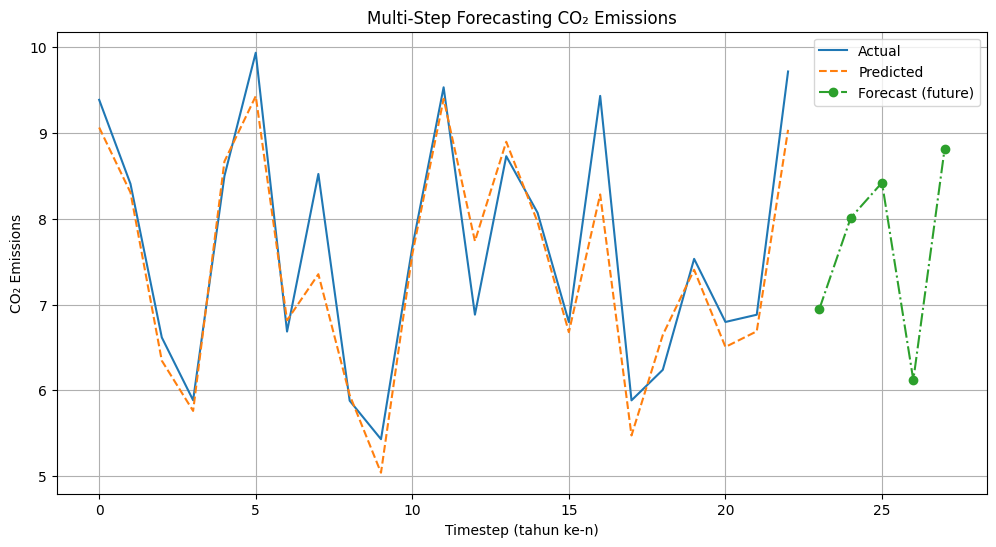

Multi-step Forecasting MSE (train set): 0.22
Prediksi 5 langkah ke depan:
  Tahun ke-1: 6.95
  Tahun ke-2: 8.01
  Tahun ke-3: 8.42
  Tahun ke-4: 6.12
  Tahun ke-5: 8.82


In [ ]:
df = pd.DataFrame({
    'Year': np.arange(1990, 2023),
    'CO2': np.random.uniform(5, 10, size=33)
})
forecast_with_preprocessing(df, window=10, epochs=500, horizon=5)

MSE (Mean Squared Error) dari train set: 0.22, yang menunjukkan seberapa akurat model dalam mempelajari pola data historis.

Artinya Grafik ini menunjukkan bahwa model forecasting yang digunakan cukup akurat dalam meniru pola data historis (karena MSE rendah), dan digunakan untuk memprediksi 5 tahun ke depan mengenai emisi CO₂.

#2. Forecast CO₂ per Benua di Dunia

In [ ]:
# Funggsi Pemetaan kode negara untuk benua
def get_continent(code):
    try:
        country_alpha2 = pycountry.countries.get(alpha_3=code).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

Fungsi get_continent(code) digunakan untuk mengonversi kode negara format alpha-3 (misalnya 'IDN') menjadi nama benua tempat negara tersebut berada. Fungsi ini bekerja dengan mengambil kode alpha-2 dari kode alpha-3 menggunakan library pycountry, lalu mengubahnya menjadi kode benua melalui pycountry_convert, dan akhirnya mengubah kode benua tersebut menjadi nama benua lengkap seperti 'Asia' atau 'Europe'. Jika terjadi kesalahan, seperti kode negara tidak valid atau tidak dikenali, fungsi akan mengembalikan None untuk mencegah program mengalami error. Fungsi ini berguna untuk analisis data geografis berdasarkan wilayah benua.

In [ ]:
# Membuat dataframe
# Buat dataframe 'codes' dari kolom 'Code' yang unik dari df
codes = df[['Entity', 'Code']].drop_duplicates().reset_index(drop=True)
codes['Region'] = codes['Code'].apply(get_continent)
codes = codes.dropna(subset=['Region'])

In [ ]:
# Simpan ke CSV untuk mendapatkan Pemetaan kode wilayah dalam benua
codes[['Code', 'Region']].to_csv("country_regions.csv", index=False)

In [ ]:
# Menggabungkan wilayah dunia
df_region = df.merge(codes, on="Code", how="left") # Mengubah 'regions' menjadi 'codes'
df_region = df_region.dropna(subset=["Region"])

In [ ]:
# Melakukan Forecasting per Benua di Dunia (tahap Preprocessing)
# Filter data
def forecast_region(region_name, window=10, epochs=100):
    region_df = df_region[df_region['Region'] == region_name]
    agg = region_df.groupby('Year')['CO2'].sum().reset_index()

    # (normalisasi)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(agg[['CO2']])
    X, y = [], []

    #Windowing (Pembuatan Urutan Input-Output):
    for i in range(len(scaled) - window):
        X.append(scaled[i:i+window])
        y.append(scaled[i+window])
    X, y = np.array(X), np.array(y)

    # GRU Model
    model = Sequential([
        GRU(64, input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X, y, epochs=epochs, verbose=0)

    # Predict
    pred = model.predict(X)
    y_true = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(pred)

    # Plot
    plt.figure(figsize=(10, 4))
    years = agg['Year'].values[window:]
    plt.plot(years, y_true, label='Actual')
    plt.plot(years, y_pred, label='Predicted')
    plt.title(f"Forecasting CO₂ - {region_name}")
    plt.xlabel("Year")
    plt.ylabel("CO₂ Emissions")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"✅ Region: {region_name} | MSE: {mean_squared_error(y_true, y_pred):.2f}")

Fungsi forecast_region(region_name, window=10, epochs=100) digunakan untuk melakukan forecasting emisi CO₂ berdasarkan wilayah atau benua tertentu. Fungsi ini mengambil subset data dari df_region sesuai dengan nama wilayah yang diberikan, lalu mengelompokkan data berdasarkan tahun dan menghitung total emisi CO₂ per tahun. Selanjutnya, data diskalakan menggunakan MinMaxScaler, dan diolah dalam bentuk jendela (windowing) agar bisa digunakan sebagai input model GRU. Model GRU dibangun dengan satu lapisan GRU (64 unit) dan satu lapisan Dense untuk menghasilkan output prediksi, kemudian dilatih dengan data yang telah disiapkan. Setelah pelatihan, model memprediksi nilai emisi, hasil prediksi dikembalikan ke skala aslinya, dan dibandingkan dengan nilai aktual. Grafik hasil prediksi dan data aktual ditampilkan untuk visualisasi performa model, dan nilai MSE dicetak sebagai ukuran kesalahan prediksi. Fungsi ini sangat berguna untuk menganalisis dan memvisualisasikan tren emisi CO₂ secara spesifik di tiap wilayah atau benua.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


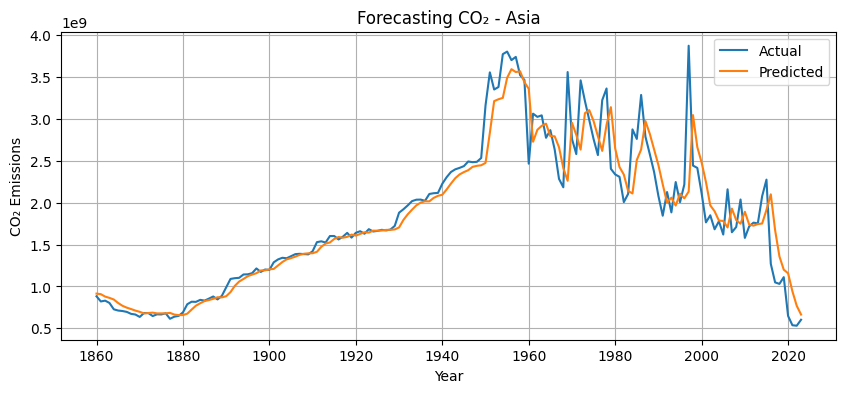

✅ Region: Asia | MSE: 91066691907758704.00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


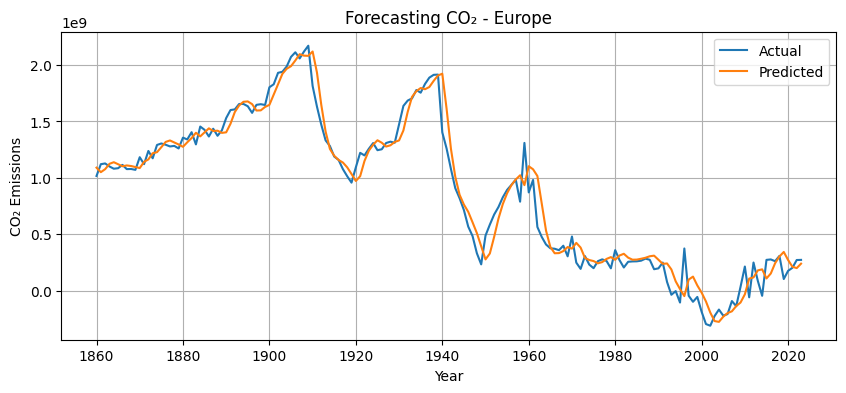

✅ Region: Europe | MSE: 16996553729973814.00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


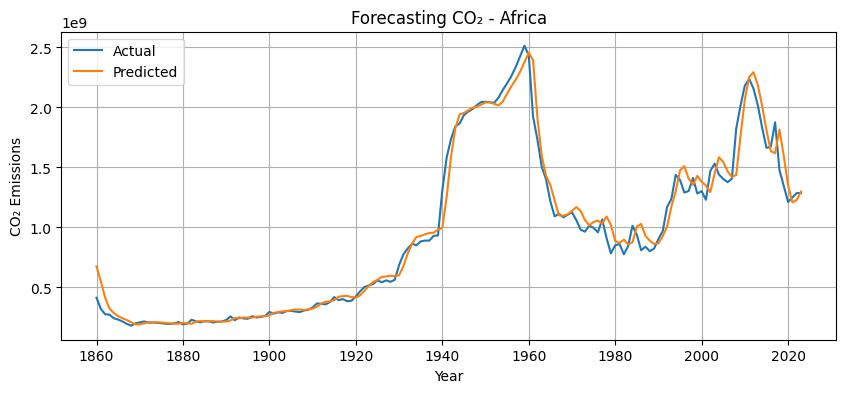

✅ Region: Africa | MSE: 11684576960667678.00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


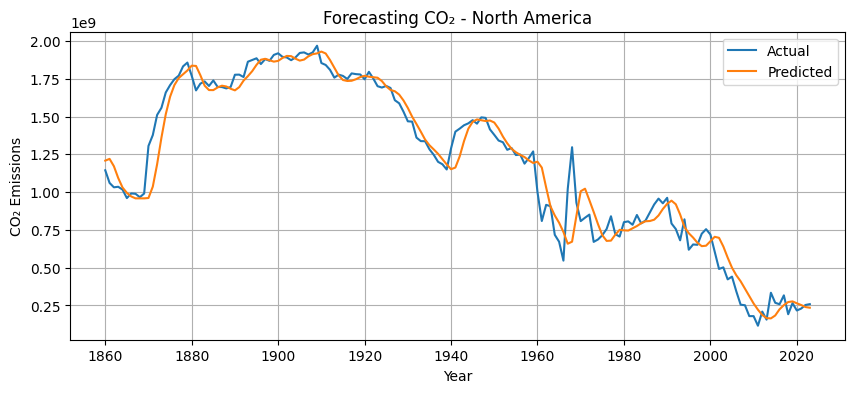

✅ Region: North America | MSE: 12899923032887010.00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


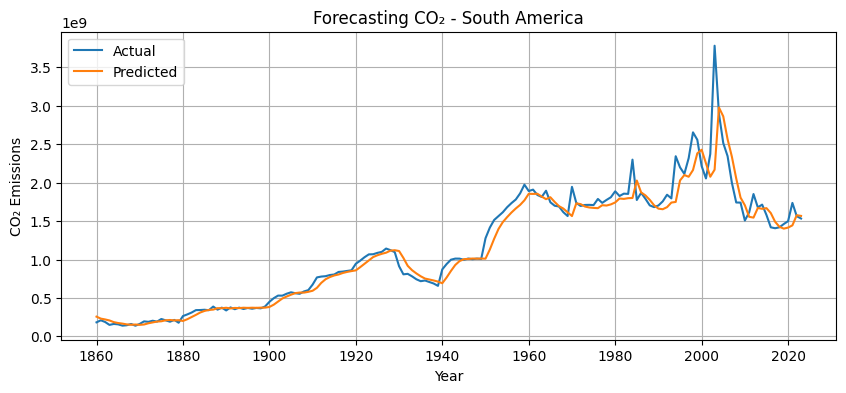

✅ Region: South America | MSE: 33360671374418976.00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


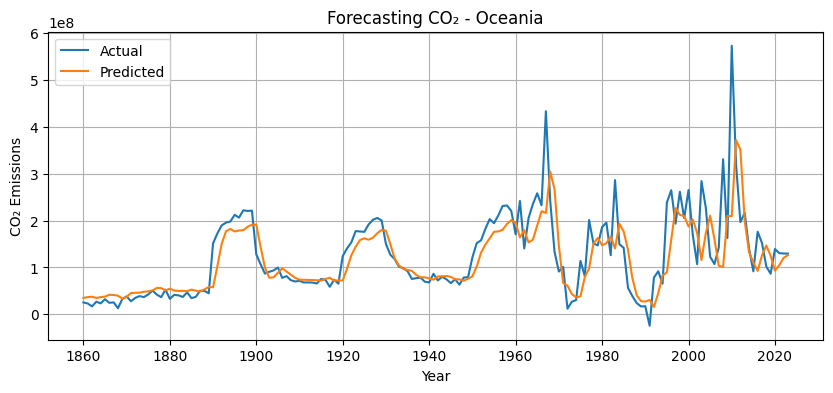

✅ Region: Oceania | MSE: 3317720721593591.50


In [ ]:
# 🔁 Forecast untuk beberapa wilayah benua
for reg in df_region['Region'].unique():
    forecast_region(reg)

# 3. Prediksi Emisi CO2 pada masing-masing benua unuk 5 tahun kedepan

Dimulai dari Indonesia

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


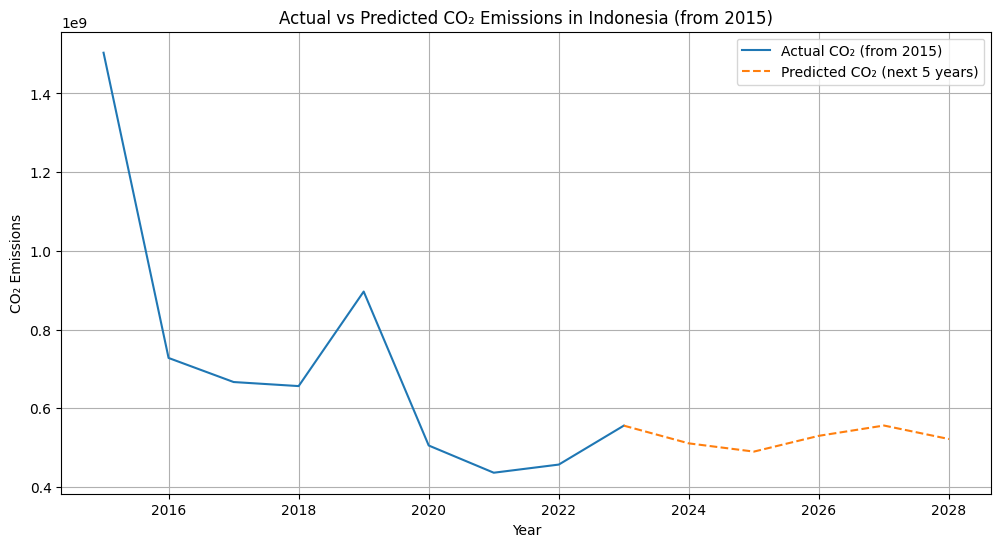

Prediksi CO₂ untuk 5 tahun ke depan di Indonesia:
Tahun 2024: 510666112.00 (ton)
Tahun 2025: 489761248.00 (ton)
Tahun 2026: 529914496.00 (ton)
Tahun 2027: 556019136.00 (ton)
Tahun 2028: 521679456.00 (ton)


In [ ]:
# Preprocessing Ambil hanya kolom CO₂ dari df_indo
co2_data_indo = df_indo['CO2'].values.reshape(-1, 1)
scaler_indo = MinMaxScaler()
scaled_indo = scaler_indo.fit_transform(co2_data_indo)

# Siapkan data untuk prediksi future
last_window_data_for_future = scaled_indo[-window:].reshape(1, window, 1)

# Lakukan prediksi 5 tahun ke depan menggunakan the pre-trained model
predicted_scaled_future = model.predict(last_window_data_for_future)

# Balikkan skala prediksi ke nilai asli menggunakan the scaler trained on df_indo
predicted_future_values = scaler_indo.inverse_transform(predicted_scaled_future.reshape(-1, 1)).flatten()

# Buat rentang tahun untuk prediksi (5 tahun ke depan setelah tahun terakhir di data)
last_year_indo = df_indo['Year'].iloc[-1]
future_years_indo = np.arange(last_year_indo + 1, last_year_indo + 1 + horizon)

# Ambil data aktual dari tahun 2015 (atau tahun yang diinginkan) untuk plot
actual_data_for_plot = df_indo[df_indo['Year'] >= 2015]

# Buat visualisasi
plt.figure(figsize=(12, 6))
# Plot data aktual dari tahun 2015
plt.plot(actual_data_for_plot['Year'], actual_data_for_plot['CO2'], label='Actual CO₂ (from 2015)')

# Plot data prediksi masa depan
last_actual_year_plot = actual_data_for_plot['Year'].iloc[-1]
last_actual_co2_plot = actual_data_for_plot['CO2'].iloc[-1]

years_for_future_plot = np.concatenate([[last_actual_year_plot], future_years_indo])
co2_for_future_plot = np.concatenate([[last_actual_co2_plot], predicted_future_values])

plt.plot(years_for_future_plot, co2_for_future_plot, label=f'Predicted CO₂ (next {horizon} years)', linestyle='--')

plt.title("Actual vs Predicted CO₂ Emissions in Indonesia (from 2015)")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.legend()
plt.grid(True)
plt.show()

print(f"Prediksi CO₂ untuk {horizon} tahun ke depan di Indonesia:")
# Add unit to the print statement
for year, co2 in zip(future_years_indo, predicted_future_values):
    print(f"Tahun {year}: {co2:.2f} (ton)") # Assuming the unit is 'ton', adjust if necessary

Kode ini digunakan untuk melakukan **prediksi emisi CO₂ di Indonesia selama 5 tahun ke depan** menggunakan model GRU yang sudah dilatih sebelumnya. Pertama, kolom 'CO2' diambil dari df_indo dan diskalakan menggunakan MinMaxScaler agar sesuai dengan skala yang digunakan saat pelatihan model. Selanjutnya, potongan data terakhir sepanjang window digunakan sebagai input model untuk memprediksi langkah berikutnya. Hasil prediksi kemudian dikembalikan ke skala aslinya.

Setelah itu, kode membuat rentang tahun masa depan berdasarkan tahun terakhir pada data, dan menggabungkan data aktual sejak 2015 dengan hasil prediksi agar dapat divisualisasikan bersama. Visualisasi memperlihatkan tren emisi aktual dari 2015 dan perbandingan prediksi untuk 5 tahun ke depan. Terakhir, hasil prediksi ditampilkan dalam bentuk angka beserta satuannya (dalam ton) untuk setiap tahun yang diprediksi.

**Kesimpulan:**
Kode ini memberikan gambaran visual dan numerik tentang prediksi emisi CO₂ di Indonesia untuk lima tahun ke depan menggunakan model GRU yang telah dilatih, memanfaatkan data historis, skala yang konsisten, dan pendekatan berbasis deret waktu untuk membantu analisis tren lingkungan nasional.


Lalu dilanjut untuk semua benua

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


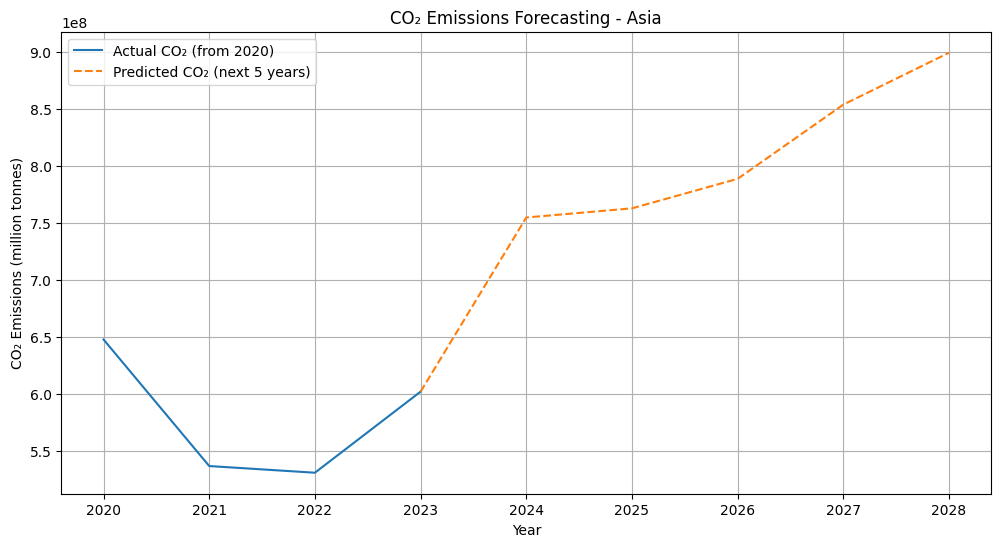

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
✅ Region: Asia | MSE (Historical Forecast): 153868370817813120.00
Prediksi CO₂ untuk 5 tahun ke depan di Asia:
  Tahun 2024: 754827712.00 juta ton
  Tahun 2025: 762864320.00 juta ton
  Tahun 2026: 788765568.00 juta ton
  Tahun 2027: 853886656.00 juta ton
  Tahun 2028: 899420736.00 juta ton
------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


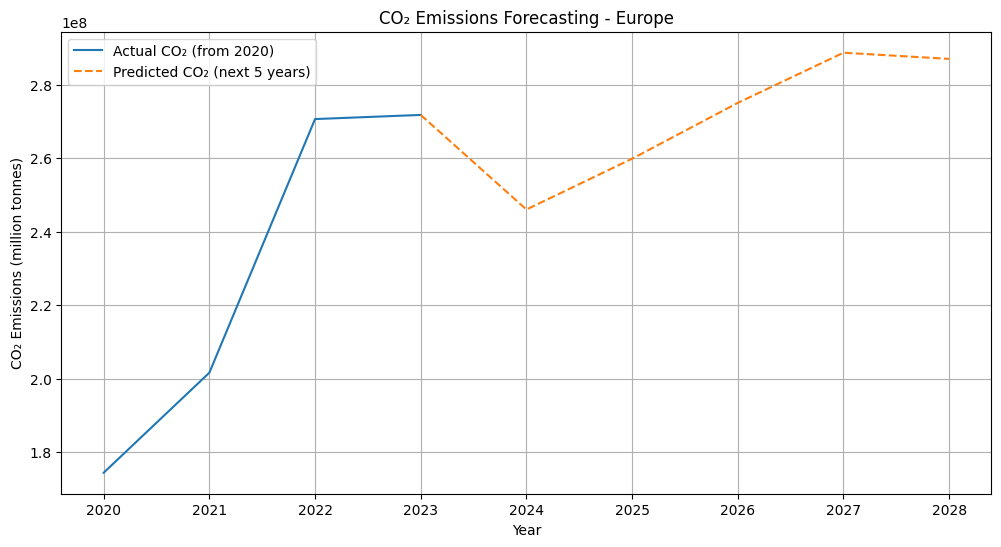

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
✅ Region: Europe | MSE (Historical Forecast): 52109588902325168.00
Prediksi CO₂ untuk 5 tahun ke depan di Europe:
  Tahun 2024: 245998304.00 juta ton
  Tahun 2025: 259814384.00 juta ton
  Tahun 2026: 275001984.00 juta ton
  Tahun 2027: 288651584.00 juta ton
  Tahun 2028: 286977376.00 juta ton
------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


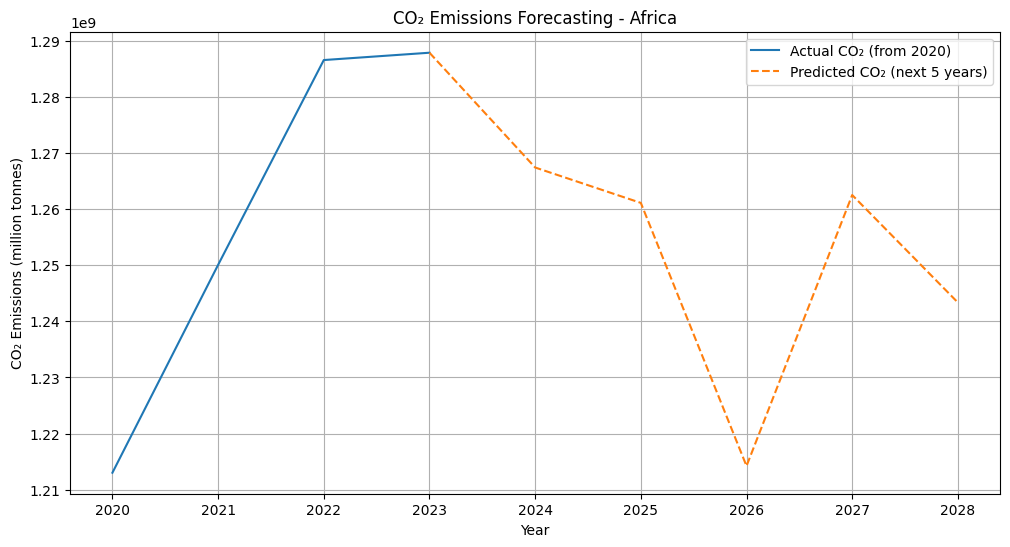

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
✅ Region: Africa | MSE (Historical Forecast): 46212906629376624.00
Prediksi CO₂ untuk 5 tahun ke depan di Africa:
  Tahun 2024: 1267407232.00 juta ton
  Tahun 2025: 1261100800.00 juta ton
  Tahun 2026: 1214214016.00 juta ton
  Tahun 2027: 1262501760.00 juta ton
  Tahun 2028: 1243348608.00 juta ton
------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


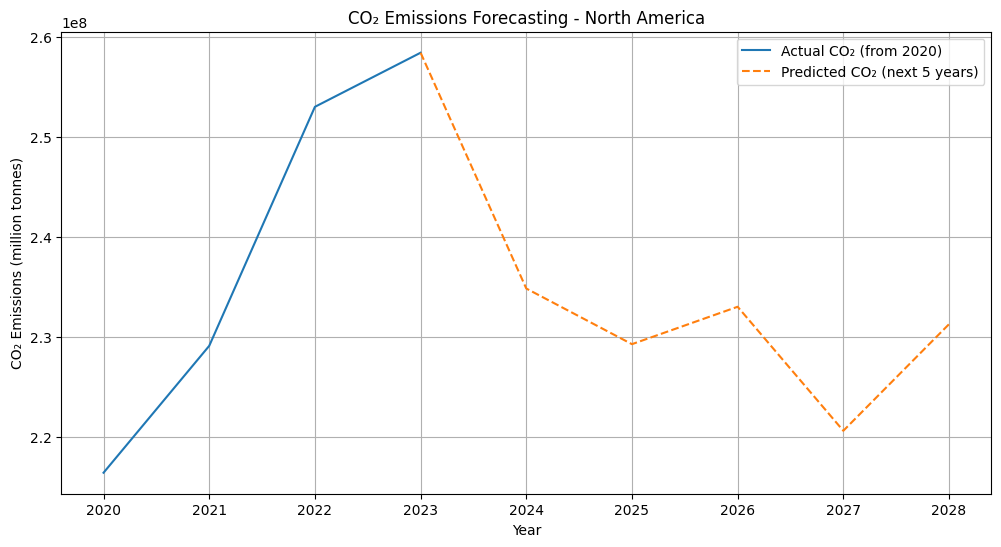

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
✅ Region: North America | MSE (Historical Forecast): 24992346299087264.00
Prediksi CO₂ untuk 5 tahun ke depan di North America:
  Tahun 2024: 234810256.00 juta ton
  Tahun 2025: 229243360.00 juta ton
  Tahun 2026: 232985568.00 juta ton
  Tahun 2027: 220579888.00 juta ton
  Tahun 2028: 231241088.00 juta ton
------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


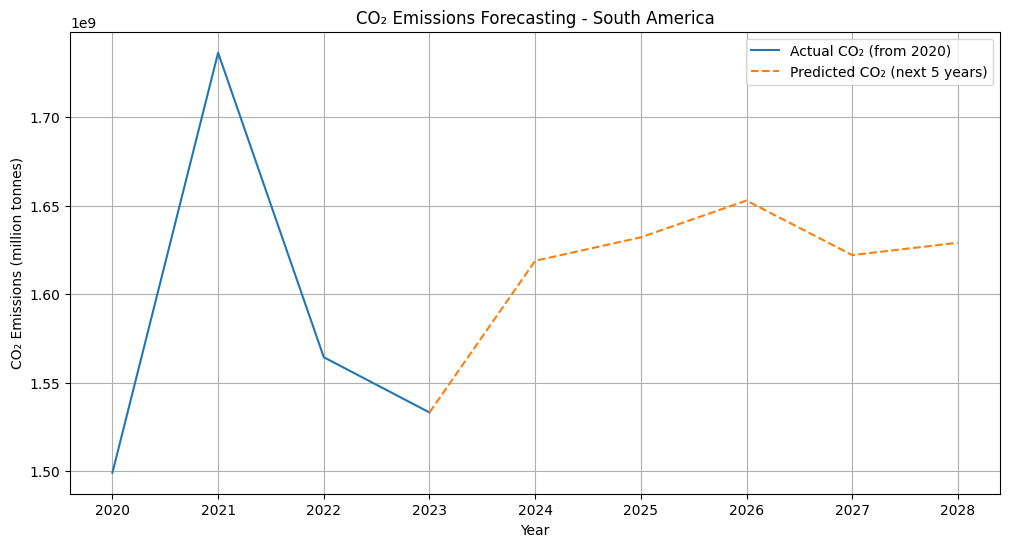

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
✅ Region: South America | MSE (Historical Forecast): 56732979160232016.00
Prediksi CO₂ untuk 5 tahun ke depan di South America:
  Tahun 2024: 1618917632.00 juta ton
  Tahun 2025: 1632209920.00 juta ton
  Tahun 2026: 1652970752.00 juta ton
  Tahun 2027: 1622163584.00 juta ton
  Tahun 2028: 1629119232.00 juta ton
------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


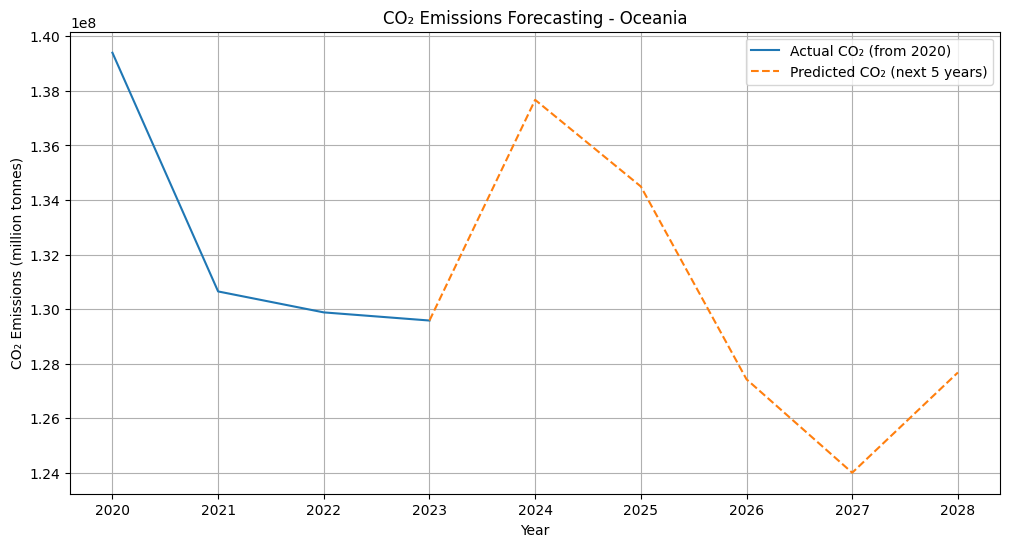

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
✅ Region: Oceania | MSE (Historical Forecast): 5145528103046902.00
Prediksi CO₂ untuk 5 tahun ke depan di Oceania:
  Tahun 2024: 137668944.00 juta ton
  Tahun 2025: 134494976.00 juta ton
  Tahun 2026: 127430760.00 juta ton
  Tahun 2027: 124007344.00 juta ton
  Tahun 2028: 127679240.00 juta ton
------------------------------


In [ ]:
# Memodifikasi fungsi forecast_region untuk menyertakan prediksi 5 tahun ke depan
def forecast_region_with_future(region_name, window=10, epochs=100, horizon=5, plot_start_year=2020):
    region_df = df_region[df_region['Region'] == region_name]
    agg = region_df.groupby('Year')['CO2'].sum().reset_index()

    # Memastikan ada cukup data untuk windowing dan horizon
    if len(agg) < window + horizon:
        print(f"Tidak cukup data untuk wilayah {region_name} ({len(agg)} data points) untuk melakukan prediksi {horizon} tahun ke depan dengan window size {window}.")
        return

    # Preprocessing
    # Scaling & Windowing menggunakan logika persiapan data multistep
    scaler = MinMaxScaler()
    # Terapkan scaler ke kolom CO2
    scaled_co2 = scaler.fit_transform(agg[['CO2']])

    # Siapkan data multi-step (input X berupa window, output y berupa horizon steps)
    X, y = [], []
    # Loop untuk membuat sampel input (X) dan output (y)
    for i in range(len(scaled_co2) - window - horizon + 1):
        X.append(scaled_co2[i : i + window]) # Ambil 'window' data sebagai input
        y.append(scaled_co2[i + window : i + window + horizon].flatten()) # Ambil 'horizon' data berikutnya sebagai output, lalu ratakan (flatten)

    X, y = np.array(X), np.array(y)

    # Periksa apakah berhasil membuat sampel data
    if len(X) == 0:
        print(f"Tidak cukup data untuk wilayah {region_name} setelah windowing dan mempertimbangkan horizon. Periksa panjang data dan ukuran window/horizon.")
        return


    # Bangun model GRU multi-output
    # Gunakan bentuk (shape) dari X untuk input shape
    model = Sequential([
        GRU(64, input_shape=(X.shape[1], X.shape[2])), # Input shape adalah (ukuran_window, jumlah_fitur=1)
        Dense(horizon) # Output sejumlah 'horizon' nilai
    ])
    model.compile(loss='mse', optimizer='adam')

    # Latih model
    # Gunakan X dan y yang sudah disiapkan untuk multi-output
    model.fit(X, y, epochs=epochs, verbose=0)


    # --- Prediksi dan Plotting ---

    # Ambil data window terakhir dari data scaled_co2 untuk membuat prediksi masa depan
    last_window_data_for_future = scaled_co2[-window:].reshape(1, window, 1)

    # Lakukan prediksi 'horizon' tahun ke depan menggunakan model multi-output
    predicted_future_scaled = model.predict(last_window_data_for_future) # Bentuk akan menjadi (1, horizon)

    # Balikkan skala prediksi ke nilai asli
    predicted_future = scaler.inverse_transform(predicted_future_scaled.reshape(-1, 1)).flatten() # Inverse transform dan ratakan

    # Buat rentang tahun untuk prediksi masa depan
    last_year_actual = agg['Year'].iloc[-1] # Tahun terakhir di data agregat
    future_years = np.arange(last_year_actual + 1, last_year_actual + 1 + horizon)


    # Plotting: Plot data aktual historis yang dimulai dari plot_start_year dan data prediksi masa depan
    plt.figure(figsize=(12, 6))

    # Ambil data aktual dari tahun plot_start_year atau setelahnya
    actual_data_from_start_year = agg[agg['Year'] >= plot_start_year]
    plt.plot(actual_data_from_start_year['Year'], actual_data_from_start_year['CO2'], label=f'Actual CO₂ (from {plot_start_year})')

    # Plot data prediksi masa depan
    # Kita perlu menghubungkan akhir data aktual yang diplot dengan awal data prediksi
    # Ambil nilai CO2 aktual terakhir yang diplot
    last_plotted_actual_year = actual_data_from_start_year['Year'].iloc[-1]
    last_plotted_actual_co2 = actual_data_from_start_year['CO2'].iloc[-1]

    years_for_future_plot = np.concatenate([[last_plotted_actual_year], future_years])
    co2_for_future_plot = np.concatenate([[last_plotted_actual_co2], predicted_future])

    plt.plot(years_for_future_plot, co2_for_future_plot, label=f'Predicted CO₂ (next {horizon} years)', linestyle='--')

    plt.title(f"CO₂ Emissions Forecasting - {region_name}")
    plt.xlabel("Year")
    plt.ylabel("CO₂ Emissions (million tonnes)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Hitung MSE pada data yang model dilatih/dievaluasi (data historis)
    # Untuk menghitung MSE, kita masih menggunakan data training/validation yang disiapkan (X, y).
    # Inverse transform y (aktual) dan pred_train_scaled (prediksi)
    y_true_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape[0], horizon) # Reshape actual sequences
    pred_train_scaled = model.predict(X) # Predict on training data
    pred_train_inv = scaler.inverse_transform(pred_train_scaled.reshape(-1, 1)).reshape(pred_train_scaled.shape[0], horizon) # Reshape predicted sequences

    mse = mean_squared_error(y_true_inv, pred_train_inv) # Compare actual sequences with predicted sequences

    print(f"✅ Region: {region_name} | MSE (Historical Forecast): {mse:.2f}")
    print(f"Prediksi CO₂ untuk {horizon} tahun ke depan di {region_name}:")
    for year, co2 in zip(future_years, predicted_future):
        print(f"  Tahun {year}: {co2:.2f} juta ton")
    print("-" * 30)

# 🔁 Forecast untuk setiap wilayah benua dengan prediksi 5 tahun ke depan, visualisasi dimulai dari 2020
for reg in df_region['Region'].unique():
    # Lewati 'World'
    if reg == 'World':
        continue
    # Panggil fungsi dengan plot_start_year=2020
    forecast_region_with_future(reg, window=10, epochs=100, horizon=5, plot_start_year=2020)

Fungsi forecast_region_with_future merupakan versi yang dimodifikasi dari fungsi sebelumnya untuk melakukan **forecasting emisi CO₂ per benua**, termasuk prediksi untuk **5 tahun ke depan**. Fungsi ini pertama-tama memfilter data berdasarkan wilayah tertentu, mengelompokkan data berdasarkan tahun, dan menjumlahkan emisi CO₂ tahunan. Data kemudian diskalakan menggunakan MinMaxScaler, dan disiapkan dalam format multistep—dengan `X` sebagai input window dan `y` sebagai target horizon (jumlah tahun ke depan). Model GRU kemudian dilatih untuk menghasilkan prediksi multi-output sesuai panjang horizon yang ditentukan.

Setelah pelatihan, prediksi 5 tahun ke depan dilakukan dengan menggunakan jendela data terakhir dari dataset historis. Hasil prediksi kemudian dikembalikan ke skala asli dan diplot bersama data aktual historis dari tahun 2020 untuk memberikan visualisasi tren yang jelas. Fungsi juga menghitung Mean Squared Error (MSE) antara data aktual dan hasil prediksi model untuk mengevaluasi performa historisnya. Di akhir, hasil prediksi untuk tiap tahun ditampilkan dalam bentuk numerik. Fungsi ini kemudian dijalankan untuk setiap wilayah benua dalam dataset, memberikan analisis tren CO₂ secara komprehensif per kawasan.

**Kesimpulan:**
Fungsi ini memungkinkan analisis prediktif jangka pendek untuk emisi CO₂ di berbagai benua dengan memanfaatkan model GRU multi-output dan teknik windowing. Visualisasi hasil dan evaluasi akurasi model melalui MSE memberikan wawasan penting terkait potensi perkembangan emisi di masing-masing wilayah.


#4. Anomaly Detection (Deteksi Emisi Tidak Normal)

In [ ]:
# Mendeteksi Anomali dengan Rolling Error (contoh: Indonesia)
df = pd.read_csv("co2-land-use.csv")
df.columns = ['Entity', 'Code', 'Year', 'CO2'] # Ensure columns are correctly named

df_indo = df[df['Entity'] == 'Indonesia'][['Year', 'CO2']].reset_index(drop=True)

In [ ]:
# Model Gru
model = Sequential([
    GRU(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=100, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Prediksi pada data yang digunakan untuk pelatihan/validasi X
pred = model.predict(X)

# Balikkan skala y_true dan pred
# y will have shape (num_samples, horizon)
y_true_scaled = y # y is already scaled
y_pred_scaled = pred

# Inverse transform them to the original scale
# Reshape y_true_scaled and y_pred_scaled to (total_elements, 1) before inverse transform
y_true_flat_scaled = y_true_scaled.flatten().reshape(-1, 1)
y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)

y_true_inv_flat = scaler.inverse_transform(y_true_flat_scaled)
y_pred_inv_flat = scaler.inverse_transform(y_pred_flat_scaled)

# Reshape back to (num_samples, horizon)
y_true_inv = y_true_inv_flat.reshape(y_true_scaled.shape[0], y_true_scaled.shape[1])
y_pred_inv = y_pred_inv_flat.reshape(y_pred_scaled.shape[0], y_pred_scaled.shape[1])

# Hitung absolute errors for each step in the horizon for each sample
errors_per_step = np.abs(y_true_inv - y_pred_inv)

# Calculate an aggregate error for each sample (e.g., mean absolute error over the horizon)
# mae_per_sample will have shape (num_samples,)
mae_per_sample = np.mean(errors_per_step, axis=1)

prediction_start_years = df_indo['Year'].values[window : window + len(mae_per_sample)]


# Calculate the threshold based on the mean absolute error per sample
threshold = np.mean(mae_per_sample) + 2 * np.std(mae_per_sample) # Example threshold

# Identify anomalies where the aggregate error exceeds the threshold
anomalies_years = prediction_start_years[mae_per_sample > threshold]
anomalies_errors = mae_per_sample[mae_per_sample > threshold]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Kode ini digunakan untuk **mendeteksi anomali dalam prediksi emisi CO₂** berdasarkan error model GRU multi-output selama pelatihan dan validasi. Prosesnya dimulai dengan melakukan prediksi (pred) menggunakan data pelatihan (X), kemudian hasil prediksi dan data target aktual (y) dikembalikan ke skala asli menggunakan inverse_transform. Setelah itu, error absolut antara nilai aktual dan prediksi dihitung untuk setiap langkah dalam horizon waktu (misalnya 5 tahun). Error tersebut dirata-rata untuk tiap sampel guna memperoleh **mean absolute error (MAE) per sample**. Kemudian, ditentukan ambang batas anomali berdasarkan rata-rata MAE ditambah dua kali standar deviasinya. Semua tahun prediksi yang memiliki MAE di atas ambang tersebut dianggap sebagai **anomali**, dan tahun-tahun ini dicatat untuk dianalisis lebih lanjut.

**Kesimpulan:**
Kode ini merupakan metode evaluasi berbasis error untuk mendeteksi **anomali prediksi** CO₂ dengan menggunakan data pelatihan model. Anomali ditentukan berdasarkan seberapa besar error prediksi menyimpang dari rata-rata kesalahan normal, sehingga dapat mengindikasikan tahun-tahun dengan pola emisi yang tidak biasa atau tidak dapat dijelaskan oleh model. Teknik ini dapat membantu mengidentifikasi momen penting yang memerlukan perhatian atau investigasi lebih lanjut.


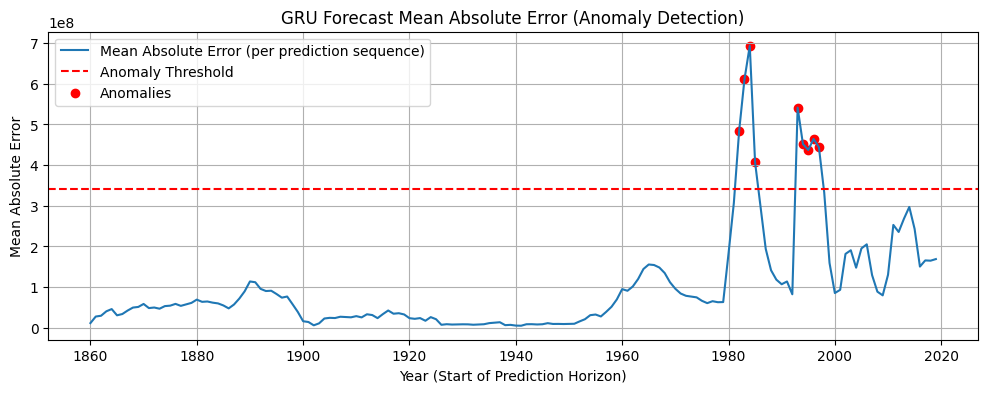

Tahun-tahun dengan Anomali yang Terdeteksi di Indonesia (berdasarkan MAE prediksi multi-langkah): [1982 1983 1984 1985 1993 1994 1995 1996 1997]


In [ ]:
# Plotting the aggregate error and anomalies
plt.figure(figsize=(12, 4))
plt.plot(prediction_start_years, mae_per_sample, label='Mean Absolute Error (per prediction sequence)')
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.scatter(anomalies_years, anomalies_errors, color='red', label='Anomalies')
plt.title("GRU Forecast Mean Absolute Error (Anomaly Detection)")
plt.xlabel("Year (Start of Prediction Horizon)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

# Print anomaly years
print("Tahun-tahun dengan Anomali yang Terdeteksi di Indonesia (berdasarkan MAE prediksi multi-langkah):", anomalies_years)

* Garis Biru (Error): Menunjukkan nilai error absolut antara hasil prediksi model GRU dan data aktual dari tahun 1850 hingga 2023.

* Garis Merah Putus-putus (Anomaly Threshold): Merupakan batas ambang error yang dianggap sebagai anomali. Jika error melebihi garis ini, maka tahun tersebut dikategorikan sebagai anomali.

* Titik Merah (Anomalies): Menunjukkan tahun-tahun di mana nilai error melampaui ambang batas (threshold), artinya model GRU mengalami kesulitan dalam memprediksi emisi CO₂ untuk tahun-tahun tersebut — kemungkinan karena adanya peristiwa luar biasa atau perubahan signifikan dalam data.

📉 Tahun-tahun dengan Anomali yang Terdeteksi di Indonesia (berdasarkan MAE prediksi multi-langkah): [1982 1983 1984 1985 1993 1994 1995 1996 1997]

Tahun-tahun ini menunjukkan waktu di mana model GRU mendeteksi ketidaksesuaian signifikan antara data aktual dan hasil prediksinya. Ini bisa disebabkan oleh faktor-faktor seperti:

* Perubahan drastis penggunaan lahan

* Kebakaran hutan besar (misalnya El Niño 1997)

* Perubahan kebijakan atau kegiatan ekonomi besar-besaran

* Peristiwa alam atau politik

# Kesimpulan


Kesimpulan
Model ini membahas penerapan model deep learning, khususnya GRU (Gated Recurrent Unit), untuk melakukan peramalan (forecasting) emisi CO₂ tahunan yang dihasilkan dari perubahan penggunaan lahan (land use change) di berbagai negara sejak tahun 1860 hingga 2023.
Dengan memanfaatkan pendekatan deep learning berbasis deret waktu, dilakukan preprocessing berupa:

1.  Normalisasi data menggunakan MinMaxScaler.
2.  Penyusunan window time series untuk prediksi multi-langkah ke depan (5 tahun).
3. Pemecahan data menjadi data latih dan uji tanpa acak (no shuffle), menjaga urutan kronologis.

Model GRU yang digunakan terdiri dari dua lapisan GRU dengan dropout, diakhiri oleh lapisan Dense untuk output horizon prediksi.

1.  Hasil pelatihan menunjukkan:

 *   Model GRU menunjukkan hasil prediksi yang cukup akurat, ditunjukkan dengan nilai MSE (Mean Squared Error) yang rendah pada data pelatihan.
 *   Visualisasi memperlihatkan bahwa nilai prediksi mengikuti tren data aktual dengan baik, dan prediksi untuk masa depan juga ditampilkan secara eksplisit.

2. Analisis Per Benua
Data emisi dari negara-negara dikelompokkan berdasarkan benua (Asia, Eropa, Afrika, Amerika Utara, Amerika Selatan, dan Oceania).

 * Model GRU kemudian dilatih untuk masing-masing benua, memberikan prediksi khusus per wilayah.

 * Hal ini memungkinkan analisis lebih mendalam terkait kontribusi regional terhadap emisi global.

3. Manfaat dan Implikasi
 * Hasil dari analisis ini dapat menjadi dasar dalam pengambilan keputusan kebijakan terkait mitigasi perubahan iklim, terutama dalam perencanaan berbasis wilayah.

 * Prediksi yang akurat terhadap emisi CO₂ sangat penting dalam mencapai target emisi rendah dan netral karbon di masa depan.

